In [1]:
!pip install keras-tuner

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense
import numpy as np
import os
import itertools 
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import tensorflow.keras as K

from keras.models import *
import tensorflow as tf
from tensorflow.keras import Model
import gc
import matplotlib.pyplot as plt
%matplotlib inline



In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/MyDrive/EEG_DL/NMED_T/Xy_psd/'

X_train = np.load(path + "x_traing.npy")


X_test = np.load(path + "x_testg.npy")



y_train = np.load(path + "y_train2.npy")


y_test = np.load(path + "y_test2.npy")

print("X",X_train.shape,X_test.shape)

print("y",y_train.shape,y_test.shape)

X (36000, 125, 125, 1) (12000, 125, 125, 1)
y (36000, 10) (12000, 10)


In [11]:
def eeg_model(hp):
  kernel_init = keras.initializers.he_uniform(seed=1369)
  kernel_reg = keras.regularizers.l2(hp.Float('kernel_reg',min_value=0.0001,max_value=0.0005,step=0.0001))#0.000114

  model = keras.models.Sequential()

  model.add(layers.Conv2D(kernel_size=(4,4),strides=(2,2),filters=32,activation="relu",
                          kernel_initializer=kernel_init,kernel_regularizer=kernel_reg,padding="same",name="layer1",input_shape=(125,125,1)))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(kernel_size=(4,4),strides=(2,2),filters=64,activation="relu",
                          kernel_initializer=kernel_init,kernel_regularizer=kernel_reg,padding="same",name="layer2"))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(kernel_size=(4,4),strides=(2,2),filters=128,activation="relu",
                          kernel_initializer=kernel_init,kernel_regularizer=kernel_reg,padding="same",name="layer3"))

  model.add(layers.BatchNormalization())
  model.add(layers.GlobalAveragePooling2D(data_format='channels_last'))
  model.add(layers.Dropout(hp.Float('dropout',min_value=0,max_value=0.4,step=0.1)))
  model.add(layers.Dense(100,activation="relu"))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(10, activation="softmax"))

  model.compile(loss='categorical_crossentropy', optimizer=hp.Choice('opt',['Adam','Nadam']), metrics=['categorical_accuracy'])

  return model 


In [15]:
import keras_tuner as kt

tuner = kt.RandomSearch(
    eeg_model,
    objective='val_loss',
    max_trials=5)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [16]:
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Trial 7 Complete [00h 16m 56s]
val_loss: 0.37730392813682556

Best val_loss So Far: 0.37730392813682556
Total elapsed time: 00h 16m 56s
INFO:tensorflow:Oracle triggered exit


In [17]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
kernel_reg: 0.00030000000000000003
dropout: 0.30000000000000004
opt: Adam
Score: 0.37730392813682556
Trial summary
Hyperparameters:
kernel_reg: 0.0002
dropout: 0.2
opt: Adam
Score: 1.2775282859802246
Trial summary
Hyperparameters:
kernel_reg: 0.0002
dropout: 0.30000000000000004
opt: Nadam
Score: 1.435633659362793
Trial summary
Hyperparameters:
kernel_reg: 0.00030000000000000003
dropout: 0.2
opt: Nadam
Score: 1.4617823362350464
Trial summary
Hyperparameters:
kernel_reg: 0.0004
dropout: 0.2
opt: Adam
Score: 1.474721074104309
Trial summary
Hyperparameters:
kernel_reg: 0.0002
dropout: 0.30000000000000004
opt: Adam
Score: 1.6135108470916748


In [18]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(125,125,1))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Conv2D)             (None, 63, 63, 32)        544       
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 32)       128       
 ormalization)                                                   
                                                                 
 layer2 (Conv2D)             (None, 32, 32, 64)        32832     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 layer3 (Conv2D)             (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_2 (Batc  (None, 16, 16, 128)      5

In [19]:
best_hps = tuner.get_best_hyperparameters(5)
model = eeg_model(best_hps[0])

history = model.fit(X_train, y_train, epochs=300, validation_data=(X_test, y_test), batch_size=500)

Epoch 1/300
72/72 [==============================] - 6s 74ms/step - loss: 2.5411 - categorical_accuracy: 0.1230 - val_loss: 2.6763 - val_categorical_accuracy: 0.1024
Epoch 2/300
72/72 [==============================] - 4s 58ms/step - loss: 2.3738 - categorical_accuracy: 0.1639 - val_loss: 2.3929 - val_categorical_accuracy: 0.1374
Epoch 3/300
72/72 [==============================] - 4s 59ms/step - loss: 2.2758 - categorical_accuracy: 0.2105 - val_loss: 2.3104 - val_categorical_accuracy: 0.2118
Epoch 4/300
72/72 [==============================] - 4s 58ms/step - loss: 2.1511 - categorical_accuracy: 0.2619 - val_loss: 2.2594 - val_categorical_accuracy: 0.2124
Epoch 5/300
72/72 [==============================] - 4s 59ms/step - loss: 1.9958 - categorical_accuracy: 0.3244 - val_loss: 2.2392 - val_categorical_accuracy: 0.2153
Epoch 6/300
72/72 [==============================] - 4s 59ms/step - loss: 1.8144 - categorical_accuracy: 0.3901 - val_loss: 2.2085 - val_categorical_accuracy: 0.2402
Epoc

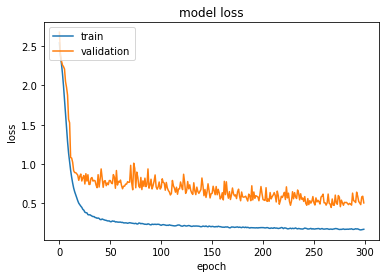

In [20]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
# predict probabilities for test set
y_pred = model.predict(X_test)
# predict crisp classes for test set
yhat_classes = np.argmax(model.predict(X_test), axis=-1)
# reduce to 1d array
#yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes.flatten()
y_test = np.argmax(y_test, axis=-1)
y_test = y_test.flatten()

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes, average='weighted')
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred,multi_class='ovr', average='weighted')
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

Accuracy: 0.897167
Precision: 0.898221
Recall: 0.897167
F1 score: 0.897294
Cohens kappa: 0.885741
ROC AUC: 0.994399
[[1087    6    8   16   14    3   36    7   16    7]
 [   1 1120    7    4   21    5    4    2   16   20]
 [   4    3 1088    9   12   25   29    6    5   19]
 [  13    2    3 1102    8   16   15   10    9   22]
 [   7   16   18    6 1087   17    9    1    6   33]
 [   5    8   35   10   29 1046    9   14   24   20]
 [  26   22   34    4    2   15 1086    0    4    7]
 [  19    8   20   27    5    8    2 1045   21   45]
 [  13   19   37   15   18   23   13    0 1042   20]
 [  18   19   14   12    3    5   44    7   15 1063]]


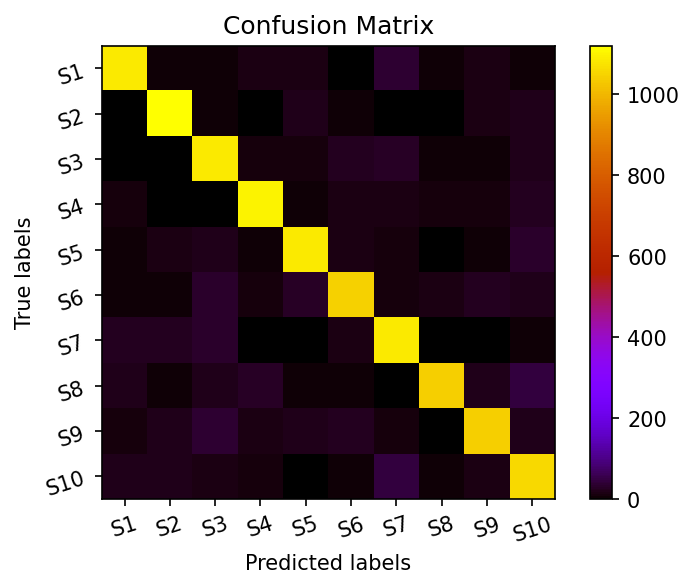

In [23]:
import matplotlib.ticker as ticker
plt.figure(dpi=150)

plt.imshow(matrix,cmap='gnuplot',extent=[0,10,0,10])

plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5], ['S1','S2','S3','S4','S5','S6','S7','S8','S9','S10'],rotation=18)
plt.yticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5], ['S10','S9','S8','S7','S6','S5','S4','S3','S2','S1'],rotation=18)

plt.title('Confusion Matrix')
plt.colorbar()
plt.show()